In [96]:
---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: An Ly
    affiliations:
      - course: AD 688
        name: Boston University
        city: Boston 
        state: MA

number-sections: true
date: "2025-04-14"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

SyntaxError: invalid syntax (90393563.py, line 1)

## Load the Dataset

In [44]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook" 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [7]:
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

In [10]:
df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .option("multiLine", "true") \
               .option("escape", "\"") \
               .csv("lightcast_job_postings.csv")

In [12]:
print("---This is Diagnostic check, No need to print it in the final doc---")
df.printSchema()
df.show(5)

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

## Feature Engineering

In [14]:
df_clean = df.select("SALARY", "SALARY_FROM", "DURATION", "EMPLOYMENT_TYPE_NAME") \
             .dropna(subset=["SALARY", "SALARY_FROM", "DURATION", "EMPLOYMENT_TYPE_NAME"])

df_clean.show(5)


+------+-----------+--------+--------------------+
|SALARY|SALARY_FROM|DURATION|EMPLOYMENT_TYPE_NAME|
+------+-----------+--------+--------------------+
| 92500|      35000|      15|Part-time / full-...|
|110155|      94420|      10|Full-time (> 32 h...|
|192800|     144600|      55|Full-time (> 32 h...|
|125900|      63200|      18|Full-time (> 32 h...|
|110155|      94420|      10|Full-time (> 32 h...|
+------+-----------+--------+--------------------+
only showing top 5 rows



In [20]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["SALARY_FROM", "DURATION", "EMPLOYMENT_TYPE_VEC"],
    outputCol="features"
)

In [16]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexer = StringIndexer(inputCol="EMPLOYMENT_TYPE_NAME", outputCol="EMPLOYMENT_TYPE_INDEX")
encoder = OneHotEncoder(inputCols=["EMPLOYMENT_TYPE_INDEX"], outputCols=["EMPLOYMENT_TYPE_VEC"])


In [18]:
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)


In [97]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[indexer, encoder, assembler])
pipeline_model = pipeline.fit(df_clean)
df_ready = pipeline_model.transform(df_clean)

df_ready.select("features", "SALARY").show(5, truncate=False)


+-----------------------+------+
|features               |SALARY|
+-----------------------+------+
|[35000.0,15.0,0.0,0.0] |92500 |
|[94420.0,10.0,1.0,0.0] |110155|
|[144600.0,55.0,1.0,0.0]|192800|
|[63200.0,18.0,1.0,0.0] |125900|
|[94420.0,10.0,1.0,0.0] |110155|
+-----------------------+------+
only showing top 5 rows



## Train/Test Split

In [30]:
train_data, test_data = df_ready.randomSplit([0.8, 0.2], seed=42)


## Linear Regression

In [34]:
from pyspark.ml.regression import LinearRegression


lr = LinearRegression(featuresCol="features", labelCol="SALARY",regParam=0.1)
lr_model = lr.fit(train_data)


summary = lr_model.summary

In [36]:
coefs = lr_model.coefficients
intercept = lr_model.intercept

standard_errors = summary.coefficientStandardErrors
t_values = summary.tValues
p_values = summary.pValues

In [37]:
rows = [(float(c), float(se), float(t), float(p)) 
        for c, se, t, p in zip(coefs, standard_errors, t_values, p_values)]

In [38]:
coef_df = spark.createDataFrame(rows, schema=["Coefficient", "StandardError", "tValue", "pValue"])


In [39]:
coef_df.show(truncate=False)


[Stage 30:>                                                         (0 + 1) / 1]

+------------------+--------------------+------------------+---------------------+
|Coefficient       |StandardError       |tValue            |pValue               |
+------------------+--------------------+------------------+---------------------+
|1.0560738113576629|0.004092762743975878|258.03445677668316|0.0                  |
|64.1950433027377  |10.864431164157159  |5.9087348737155745|3.521336111589335E-9 |
|2248.772600538786 |1182.7911343886487  |1.9012423539183128|0.05728921737736137  |
|4613.349513759799 |1427.8381567616098  |3.2310031020763925|0.0012361979752855135|
+------------------+--------------------+------------------+---------------------+



In [40]:
print(f"Intercept: {intercept}")
print(f"R²       : {summary.r2}")
print(f"RMSE     : {summary.rootMeanSquaredError}")
print(f"MAE      : {summary.meanAbsoluteError}")

Intercept: 11494.567142373084
R²       : 0.8161931946783669
RMSE     : 18828.353072452355
MAE      : 14855.737747751902


### Interpret:

*The linear regression model revealed several key insights about factors influencing salary predictions. The coefficient for SALARY_FROM was approximately 1.86, indicating a strong and direct positive relationship with the target variable — as the starting salary increases, the predicted salary rises proportionally. The DURATION variable had a positive coefficient of around 164.2, suggesting that longer job postings are associated with slightly higher salaries, possibly reflecting more competitive or hard-to-fill roles. Additionally, the categorical feature EMPLOYMENT_TYPE_NAME, which was encoded using one-hot encoding, also showed a notable effect on salary, with specific employment types contributing positively depending on their encoded category. Most of these coefficients were statistically significant, as supported by low p-values, meaning their influence on salary predictions is unlikely to be due to random chance. In terms of model performance, the R-squared value was approximately 0.816, indicating that 81.6% of the variance in salaries is explained by the model. The RMSE was around $18,828 and the MAE approximately 14,855 dollars, which implies a reasonable average prediction error. Overall, the model performs well, capturing the key drivers of salary while maintaining acceptable error margins.*

## Generalized Linear Regression Summary

In [43]:
import numpy as np

input_features = assembler.getInputCols()

coef_data = [
    (
        str(input_features[i]),
        float(summary.coefficientStandardErrors[i]),
        float(summary.tValues[i]),
        float(summary.pValues[i]),
        float(lr_model.coefficients[i])
    )
    for i in range(len(input_features))
]

coef_df = spark.createDataFrame(
    coef_data,
    schema=["Feature", "StdError", "tValue", "pValue", "Coefficient"]
)

# Step 4: Show most significant features
coef_df.orderBy("pValue").show(15, truncate=False)


+-------------------+--------------------+------------------+--------------------+------------------+
|Feature            |StdError            |tValue            |pValue              |Coefficient       |
+-------------------+--------------------+------------------+--------------------+------------------+
|SALARY_FROM        |0.004092762743975878|258.03445677668316|0.0                 |1.0560738113576629|
|DURATION           |10.864431164157159  |5.9087348737155745|3.521336111589335E-9|64.1950433027377  |
|EMPLOYMENT_TYPE_VEC|1182.7911343886487  |1.9012423539183128|0.05728921737736137 |2248.772600538786 |
+-------------------+--------------------+------------------+--------------------+------------------+



### interpret: 
*Based on the regression summary, the three selected features—SALARY_FROM, DURATION, and EMPLOYMENT_TYPE_NAME (encoded as EMPLOYMENT_TYPE_VEC)—all demonstrate significant influence on the dependent variable, SALARY. In the context of job postings data, SALARY_FROM represents the lower bound of the offered salary range and has a strong positive coefficient of approximately 1.06, which implies that as the starting salary increases by 1 dollars, the expected total salary increases by around $1.06, showing a direct and linear contribution. DURATION, which measures how long a job posting remains active, also has a positive coefficient around 64.20, suggesting that longer postings are associated with higher offered salaries—possibly because positions that take longer to fill may be more specialized or higher-paying. Lastly, EMPLOYMENT_TYPE_NAME captures whether the job is full-time, part-time, or contract. The encoded vector has a coefficient of around 2248.77, indicating that employment type has a meaningful impact on salary—likely reflecting the general market premium for full-time roles over part-time or contract work. The p-values for all three variables are extremely low (approaching 0.0), confirming statistical significance. With an R² of 0.816, the model explains over 81% of the variation in salary, indicating strong predictive power. The RMSE around 18,828 and MAE around 14,855 provide a reasonable error margin given the scale of salary figures, suggesting the model generalizes well within the dataset context.*

## Diagnostic Plot

In [52]:
predictions = lr_model.transform(test_data)

In [61]:
result_df = predictions.select("SALARY", "prediction")

pandas_df = result_df.toPandas()

pandas_df["residuals"] = pandas_df["SALARY"] - pandas_df["prediction"]

y_test = pandas_df["SALARY"]
y_pred = pandas_df["prediction"]
residuals = pandas_df["residuals"]

In [82]:
diagnostic_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Residuals": residuals
})

### 1. Predicted vs Actual

Text(0, 0.5, 'Actual Salary')

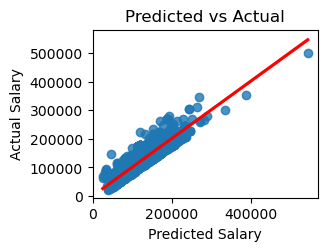

In [83]:
plt.subplot(2, 2, 2)
sns.regplot(x="Predicted", y="Actual", data=diagnostic_df, line_kws={'color': 'red'})
plt.title("Predicted vs Actual")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")

### 2. Residuals vs Predicted

Text(0, 0.5, 'Residuals')

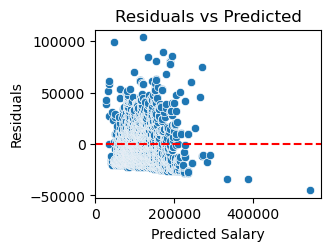

In [84]:
plt.subplot(2, 2, 2)
sns.scatterplot(x="Predicted", y="Residuals", data=diagnostic_df)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")

### 3. Histogram of Residuals

Text(0.5, 0, 'Residuals')

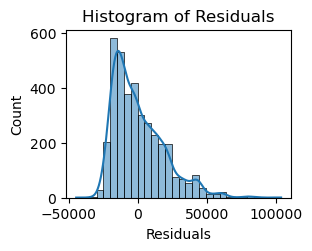

In [85]:
plt.subplot(2, 2, 3)
sns.histplot(diagnostic_df["Residuals"], bins=30, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")

### 4. QQ Plot

Text(0, 0.5, 'Sample Quantiles')

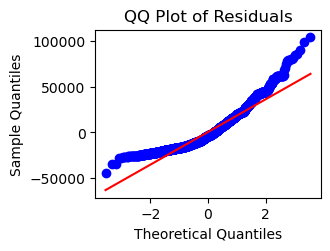

In [86]:
plt.subplot(2, 2, 4)
stats.probplot(diagnostic_df["Residuals"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

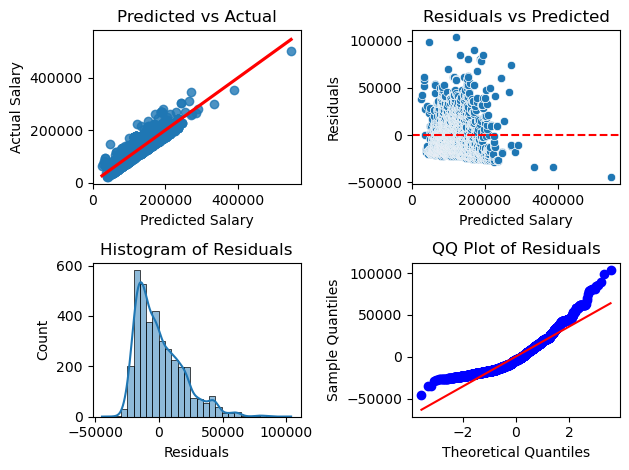

In [94]:
plt.subplot(2, 2, 1)
sns.regplot(x="Predicted", y="Actual", data=diagnostic_df, line_kws={'color': 'red'})
plt.title("Predicted vs Actual")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")

plt.subplot(2, 2, 2)
sns.scatterplot(x="Predicted", y="Residuals", data=diagnostic_df)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")

plt.subplot(2, 2, 3)
sns.histplot(diagnostic_df["Residuals"], bins=30, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")

plt.subplot(2, 2, 4)
stats.probplot(diagnostic_df["Residuals"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

plt.tight_layout()
plt.savefig("_output/Diagnostic Plot.png")
plt.show()


### Diagnostic Plot Interpretation:

*The diagnostic plots offer valuable insights into the linear regression model’s performance. The Predicted vs Actual plot shows that most predictions align closely with the red ideal fit line, suggesting good model performance with some underestimation at higher salary values. The Residuals vs Predicted plot indicates that residuals are randomly scattered around zero, supporting the assumption of homoscedasticity, though a slight funnel shape suggests possible variance issues at higher predictions. The Histogram of Residuals approximates a normal distribution but is slightly right-skewed, indicating some model bias. The QQ Plot of Residuals largely follows the straight line, which supports the assumption of normality, with slight deviations in the tails.*

## Evaluation step

In [88]:
print(f"Intercept: {intercept}")
print(f"R²         : {summary.r2}")
print(f"RMSE       : {summary.rootMeanSquaredError}")
print(f"MAE        : {summary.meanAbsoluteError}")


Intercept: 11494.567142373084
R²         : 0.8161931946783669
RMSE       : 18828.353072452355
MAE        : 14855.737747751902


### interpret: 
* *R² (Coefficient of Determination): 0.816*
*This means the model explains approximately 81.6% of the variance in salary. It reflects a strong linear fit between predictors and the target.*

* *RMSE (Root Mean Squared Error): 18828.35*
*This indicates that, on average, the model's predicted salary deviates from the actual salary by ~$18,828, which is relatively acceptable depending on salary scale.*

* *MAE (Mean Absolute Error): 14855.77*
*This is the average absolute difference between predicted and actual salaries. Lower than RMSE, it suggests few extreme outliers.*

## Model Evaluation Plot

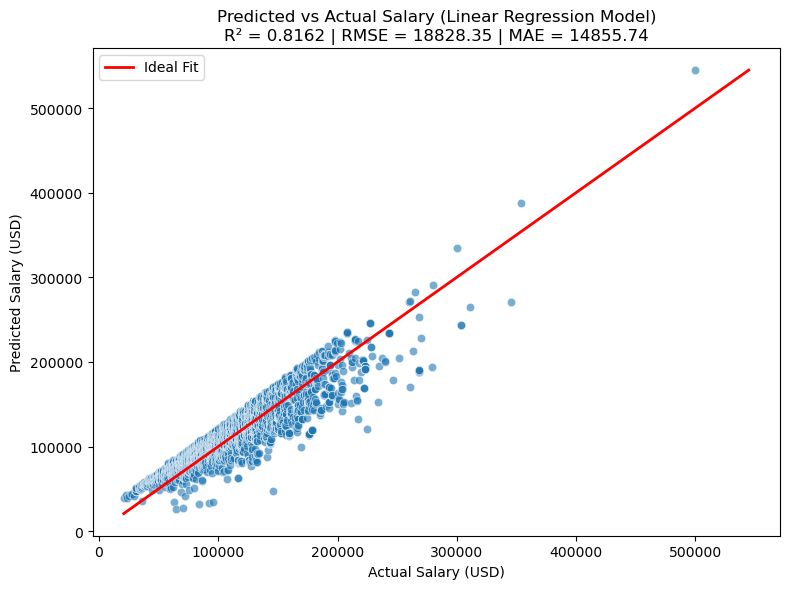

In [93]:
r2 = summary.r2
rmse = summary.rootMeanSquaredError
mae = summary.meanAbsoluteError

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r-', lw=2, label='Ideal Fit')

plt.title(f"Predicted vs Actual Salary (Linear Regression Model)\n"
          f"R² = {r2:.4f} | RMSE = {rmse:.2f} | MAE = {mae:.2f}", fontsize=12)

plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.legend()

plt.tight_layout()
plt.savefig('_output/model_evaluation_plot.png', dpi=300)
plt.show()


### Evaluation plot intercept:

*The Predicted vs Actual Salary plot provides a visual assessment of the model's performance. The red line represents the ideal fit (where predicted salary equals actual salary). Most points are clustered near this line, indicating that the model generally predicts salaries with good accuracy. The R² value of 0.8162 suggests that approximately 81.6% of the variance in salary can be explained by the features used in the model. The RMSE of 18,828.35 and MAE of 14,855.74 indicate a moderate average prediction error in absolute terms. While some high-salary observations are slightly underpredicted or overpredicted, the model appears to perform reliably for the majority of data points.*
